In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

In [8]:
energy_data = pd.read_csv('energy_dataset.csv', error_bad_lines=False)
energy_data.head()

time  generation biomass  \
0  2015-01-01 00:00:00+01:00               447.0   
1  2015-01-01 01:00:00+01:00               449.0   
2  2015-01-01 02:00:00+01:00               448.0   
3  2015-01-01 03:00:00+01:00               438.0   
4  2015-01-01 04:00:00+01:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                       4755.0                  158.0   
2                 4857.0                       4581.0                  157.0   
3                 4314.0                       4131.0                  160.0   
4                 4130.0                       3840.0                  156.0   

   generation fossil oil shale  generation fossil peat  generation geothermal  \
0                          0.0                     0.0                    0.0   
1                          0.0                     0.0                    0.0   
2                          0.0                     0.0                    0.0   
3                          0.0                     0.0                    0.0   
4                          0.0                     0.0                    0.0   

   ...  generation waste  generation wind offshore  generation wind onshore  \
0  ...             196.0                       0.0                   6378.0   
1  ...             195.0                       0.0                   5890.0   
2  ...             196.0                       0.0                   5461.0   
3  ...             191.0                       0.0                   5238.0   
4  ...             189.0                       0.0                   4935.0   

   forecast solar day ahead  forecast wind offshore eday ahead  \
0                      17.0                                NaN   
1                      16.0                                NaN   
2                       8.0                                NaN   
3                       2.0                                NaN   
4                       9.0                                NaN   

   forecast wind onshore day ahead  total load forecast  total load actual  \
0                           6436.0              26118.0            25385.0   
1                           5856.0              24934.0            24382.0   
2                           5454.0              23515.0            22734.0   
3                           5151.0              22642.0            21286.0   
4                           4861.0              21785.0            20264.0   

   price day ahead  price actual  
0            50.10         65.41  
1            48.10         64.92  
2            47.33         64.48  
3            42.27         59.32  
4            38.41         56.04  

[5 rows x 29 columns]

In [13]:
energy_data.isnull().sum()

time                                           0
generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
forecast solar day ahead                       0
forecast wind onshore day ahead                0
total load forecast                            0
total load actual                              0
price day ahead                                0
price actual        

In [10]:
energy_data = energy_data.drop(['generation fossil coal-derived gas','generation fossil oil shale','generation fossil peat','generation geothermal','generation marine','generation wind offshore', 'forecast wind offshore eday ahead', 'generation hydro pumped storage aggregated'],axis=1)

In [12]:
energy_data.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [17]:
energy_data_without_time = energy_data.drop(['time'], axis=1)

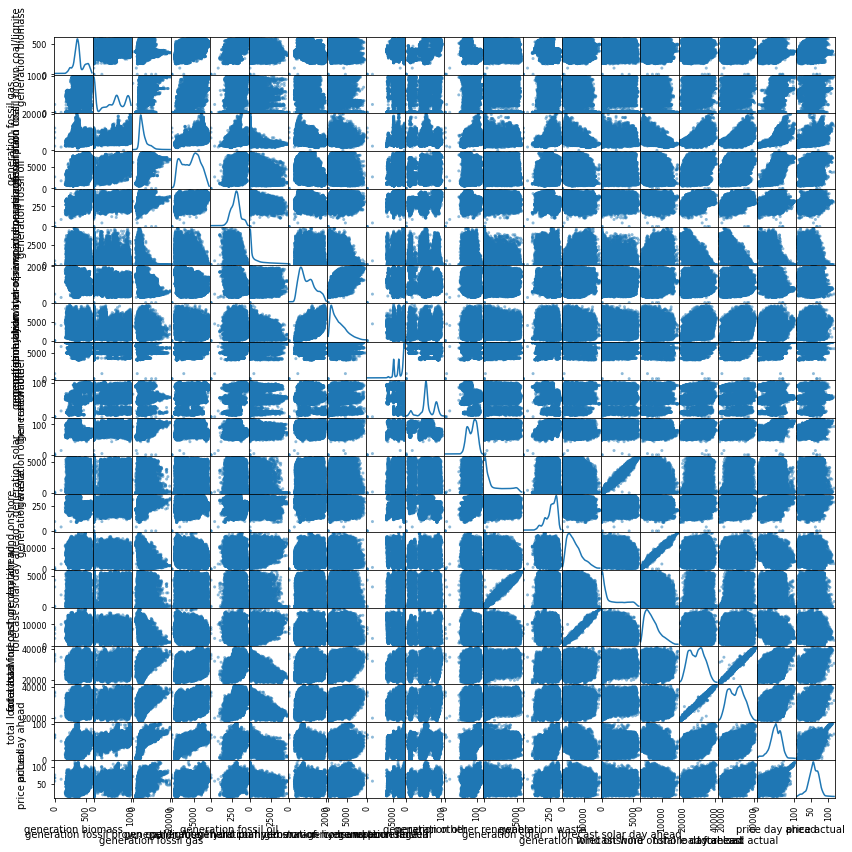

In [18]:
pd.plotting.scatter_matrix(energy_data_without_time,  diagonal='kde', figsize=(14,14))
plt.show()

In [24]:
energy_subsample = energy_data_without_time[['generation solar', 'generation waste', 'generation wind onshore', 'forecast solar day ahead', 'forecast wind onshore day ahead', 'total load forecast', 'price day ahead','price actual', 'total load actual']]
energy_subsample.head()/

generation solar  generation waste  generation wind onshore  \
0              49.0             196.0                   6378.0   
1              50.0             195.0                   5890.0   
2              50.0             196.0                   5461.0   
3              50.0             191.0                   5238.0   
4              42.0             189.0                   4935.0   

   forecast solar day ahead  forecast wind onshore day ahead  \
0                      17.0                           6436.0   
1                      16.0                           5856.0   
2                       8.0                           5454.0   
3                       2.0                           5151.0   
4                       9.0                           4861.0   

   total load forecast  price day ahead  price actual  total load actual  
0              26118.0            50.10         65.41            25385.0  
1              24934.0            48.10         64.92            24382.0  
2              23515.0            47.33         64.48            22734.0  
3              22642.0            42.27         59.32            21286.0  
4              21785.0            38.41         56.04            20264.0

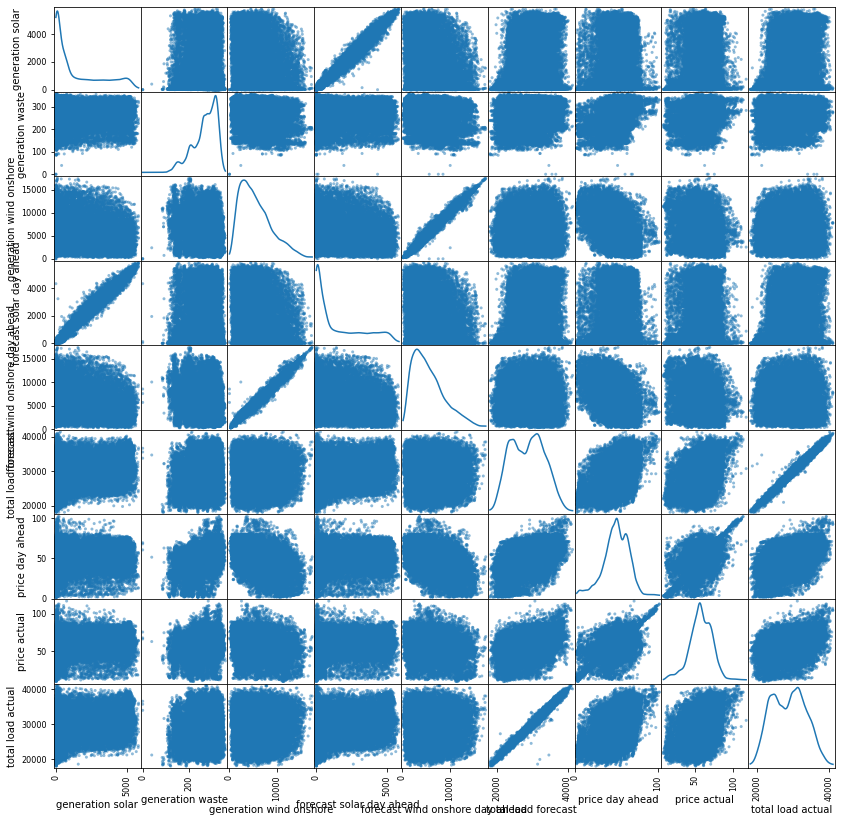

In [25]:
pd.plotting.scatter_matrix(energy_subsample,  diagonal='kde', figsize=(14,14))
plt.show()

In [23]:
pd.concat((energy_subsample.mean(), energy_subsample.var()), axis=1, keys=['mean', 'var'])

mean           var
generation solar                  1432.818546  2.822271e+06
generation waste                   269.418692  2.521890e+03
generation wind onshore           5464.980450  1.032714e+07
forecast solar day ahead          1439.066735  2.814689e+06
forecast wind onshore day ahead   5471.216689  1.008896e+07
total load forecast              28712.129962  2.110576e+07
price day ahead                     49.874341  2.137122e+02
price actual                        57.884023  2.017560e+02

In [36]:
energy_subsample_cond = energy_subsample[['generation solar', 'generation wind onshore', 'total load forecast', 'price day ahead','price actual', 'total load actual']]
energy_subsample_cond

generation solar  generation wind onshore  total load forecast  \
0                  49.0                   6378.0              26118.0   
1                  50.0                   5890.0              24934.0   
2                  50.0                   5461.0              23515.0   
3                  50.0                   5238.0              22642.0   
4                  42.0                   4935.0              21785.0   
...                 ...                      ...                  ...   
35059              85.0                   3113.0              30619.0   
35060              33.0                   3288.0              29932.0   
35061              31.0                   3503.0              27903.0   
35062              31.0                   3586.0              25450.0   
35063              31.0                   3651.0              24424.0   

       price day ahead  price actual  total load actual  
0                50.10         65.41            25385.0  
1                48.10         64.92            24382.0  
2                47.33         64.48            22734.0  
3                42.27         59.32            21286.0  
4                38.41         56.04            20264.0  
...                ...           ...                ...  
35059            68.85         77.02            30653.0  
35060            68.40         76.16            29735.0  
35061            66.88         74.30            28071.0  
35062            63.93         69.89            25801.0  
35063            64.27         69.88            24455.0  

[35064 rows x 6 columns]

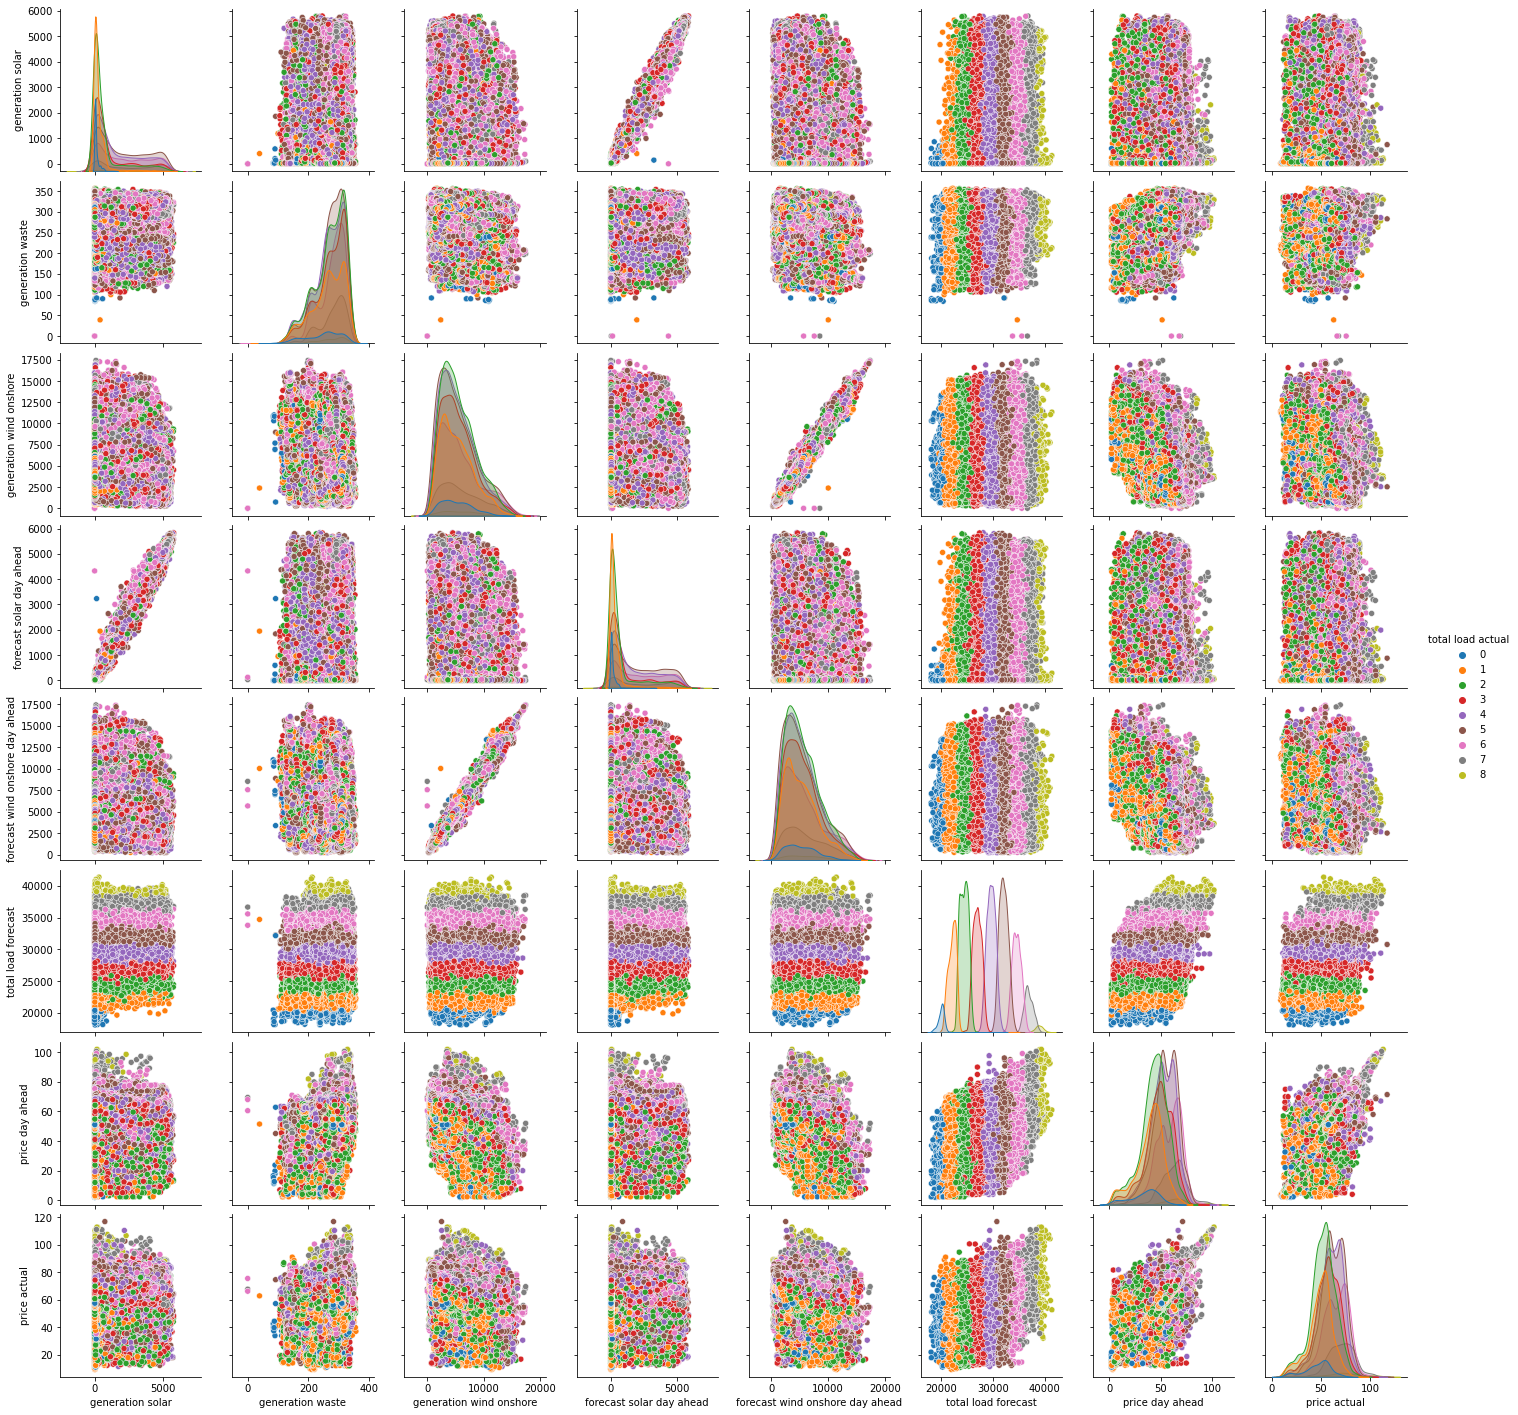

In [39]:
energy_subsample_dicr = energy_subsample.copy()
energy_subsample_dicr['total load actual'] = pd.cut(energy_subsample_dicr['total load actual'], bins=9, labels=np.arange(9), right=False)
sns.pairplot(energy_subsample_dicr, hue='total load actual', diag_kind='kde')

In [40]:
pd.concat([energy_subsample[energy_subsample_dicr['total load actual'] == level].mean() for level in energy_subsample_dicr['total load actual'].unique()] +\
          [energy_subsample[energy_subsample_dicr['total load actual'] == level].var() for level in energy_subsample_dicr['total load actual'].unique()], axis=1,\
          keys=[f'mean_{level}' for level in energy_subsample_dicr['total load actual'].unique()] +\
          [f'var_{level}' for level in energy_subsample_dicr['total load actual'].unique()])

mean_2        mean_1        mean_0  \
generation solar                   765.991310    340.426792    125.462687   
generation waste                   268.957858    262.608823    245.452239   
generation wind onshore           5482.535396   5237.692765   5187.252239   
forecast solar day ahead           759.078655    327.282990    127.834328   
forecast wind onshore day ahead   5494.051916   5259.024663   5232.617910   
total load forecast              24411.282721  22131.257310  20054.632836   
price day ahead                     43.458095     39.523361     33.741896   
price actual                        51.762694     48.979677     46.171164   
total load actual                24418.489054  22123.154844  19926.220149   

                                       mean_3        mean_4        mean_5  \
generation solar                  1162.859534   1726.051566   2106.413478   
generation waste                   271.873100    267.360402    270.149961   
generation wind onshore           5461.713681   5363.777671   5392.683656   
forecast solar day ahead          1163.740042   1728.513574   2122.846940   
forecast wind onshore day ahead   5472.590725   5362.380884   5394.698993   
total load forecast              26953.328074  29625.378153  32043.370875   
price day ahead                     48.041149     51.876647     54.569944   
price actual                        56.377112     59.442749     61.626381   
total load actual                26953.859438  29591.216064  31996.340382   

                                       mean_6        mean_7        mean_8  \
generation solar                  2158.758487   2259.019366   2169.148148   
generation waste                   275.152169    278.389378    275.662551   
generation wind onshore           5732.966407   5956.705106   5904.000000   
forecast solar day ahead          2197.743753   2271.675469   2171.111111   
forecast wind onshore day ahead   5729.518859   5953.634390   5861.781893   
total load forecast              34544.876473  36873.461268  38958.868313   
price day ahead                     57.666308     62.625998     68.480576   
price actual                        64.859538     70.786109     76.033992   
total load actual                34543.869716  36909.215669  39136.057613   

                                        var_2         var_1         var_0  \
generation solar                 1.628856e+06  5.091139e+05  3.140330e+04   
generation waste                 2.650972e+03  2.953796e+03  3.628395e+03   
generation wind onshore          9.114171e+06  8.392879e+06  7.205093e+06   
forecast solar day ahead         1.643282e+06  5.014486e+05  5.465670e+04   
forecast wind onshore day ahead  8.991002e+06  8.429043e+06  7.381819e+06   
total load forecast              6.582130e+05  6.202119e+05  7.755097e+05   
price day ahead                  1.814510e+02  1.859864e+02  1.991829e+02   
price actual                     1.656896e+02  1.609851e+02  1.785821e+02   
total load actual                5.379115e+05  4.970527e+05  2.764978e+05   

                                        var_3         var_4         var_5  \
generation solar                 2.316064e+06  2.804798e+06  3.092304e+06   
generation waste                 2.587872e+03  2.564868e+03  2.303421e+03   
generation wind onshore          9.518067e+06  9.860446e+06  1.140460e+07   
forecast solar day ahead         2.325598e+06  2.734998e+06  3.023710e+06   
forecast wind onshore day ahead  9.375114e+06  9.577379e+06  1.101974e+07   
total load forecast              7.187256e+05  7.318437e+05  7.527462e+05   
price day ahead                  1.807097e+02  1.534120e+02  1.466349e+02   
price actual                     1.669489e+02  1.628536e+02  1.564141e+02   
total load actual                5.312707e+05  5.116018e+05  5.304128e+05   

                                        var_6         var_7         var_8  
generation solar                 3.144808e+06  3.896032e+06  4.310396e+06  
generation waste                

In [41]:
def pearsonr_ci(x, y, alpha=0.05):
    # calculates Pearson correlation along with the confidence interval using scipy and numpy
    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

<ipython-input-41-0193bd620d56>:4: RuntimeWarning: divide by zero encountered in arctanh
  r_z = np.arctanh(r)


Text(0.5, 1.0, 'Upper bound of confidence interval')

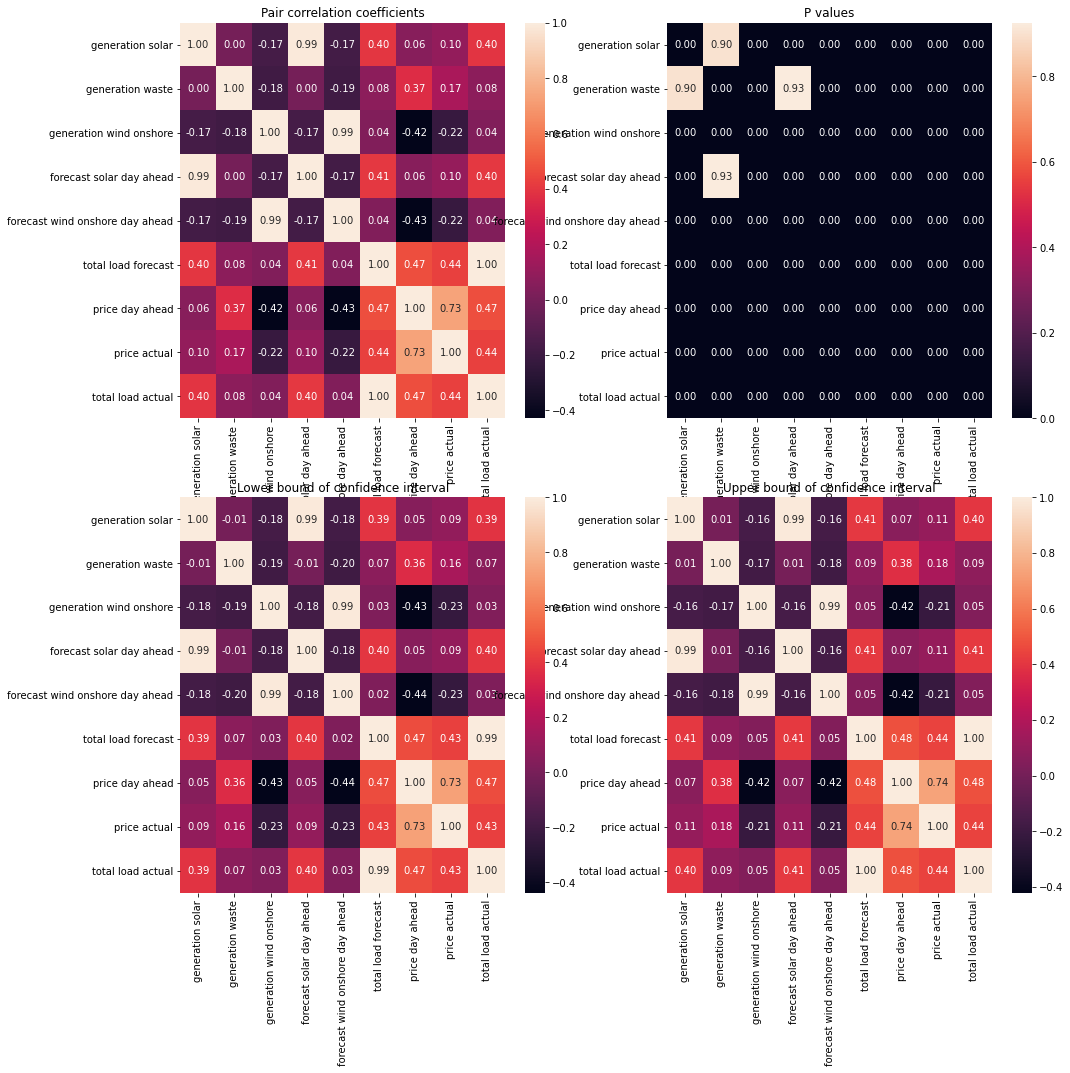

In [43]:
r_mat = pd.DataFrame({col: np.zeros(9) for col in energy_subsample.columns}, index=energy_subsample.columns)
p_mat = pd.DataFrame({col: np.zeros(9) for col in energy_subsample.columns}, index=energy_subsample.columns)
lo_mat = pd.DataFrame({col: np.zeros(9) for col in energy_subsample.columns}, index=energy_subsample.columns)
hi_mat = pd.DataFrame({col: np.zeros(9) for col in energy_subsample.columns}, index=energy_subsample.columns)
for col1 in energy_subsample.columns:
  for col2 in energy_subsample.columns:
    r, p, lo, hi = pearsonr_ci(energy_subsample[col1], energy_subsample[col2])
    r_mat.loc[col1, col2] = r
    p_mat.loc[col1, col2] = p
    lo_mat.loc[col1, col2] = lo
    hi_mat.loc[col1, col2] = hi
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
sns.heatmap(r_mat, annot=True, ax=axs[0][0], fmt='.2f')
axs[0][0].set_title('Pair correlation coefficients')
sns.heatmap(p_mat, annot=True, ax=axs[0][1], fmt='.2f')
axs[0][1].set_title('P values')
sns.heatmap(lo_mat, annot=True, ax=axs[1][0], fmt='.2f')
axs[1][0].set_title('Lower bound of confidence interval')
sns.heatmap(hi_mat, annot=True, ax=axs[1][1], fmt='.2f')
axs[1][1].set_title('Upper bound of confidence interval')

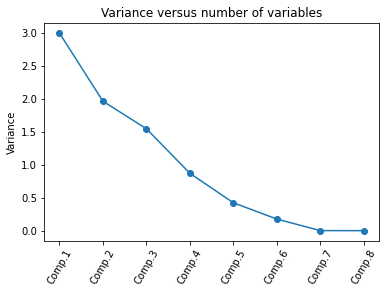

In [45]:
standardisedX = scale(energy_subsample.drop(columns=['total load actual']))
standardisedX = pd.DataFrame(standardisedX, index=energy_subsample.index, columns=[x for x in energy_subsample.columns if x != 'total load actual'])
pca = PCA().fit(standardisedX)
y = energy_subsample['total load actual']

def screeplot(pca, standardised_values):
    y = np.std(pca.transform(standardised_values), axis=0)**2
    x = np.arange(len(y)) + 1
    plt.plot(x, y, "o-")
    plt.xticks(x, ["Comp."+str(i) for i in x], rotation=60)
    plt.ylabel("Variance")
    plt.title('Variance versus number of variables')
    plt.show()

screeplot(pca, standardisedX)

In [47]:
X = energy_subsample.drop(columns=['total load actual'])
y = energy_subsample['total load actual']
edge = len(energy_subsample) * 7 // 10
X_train = X[:edge]
X_test = X[edge:]
y_train = y[:edge]
y_test = y[edge:]

Resulting mean absolute error is 304.6898, mean squared error is 181654.8702, determination coefficient is 0.9916


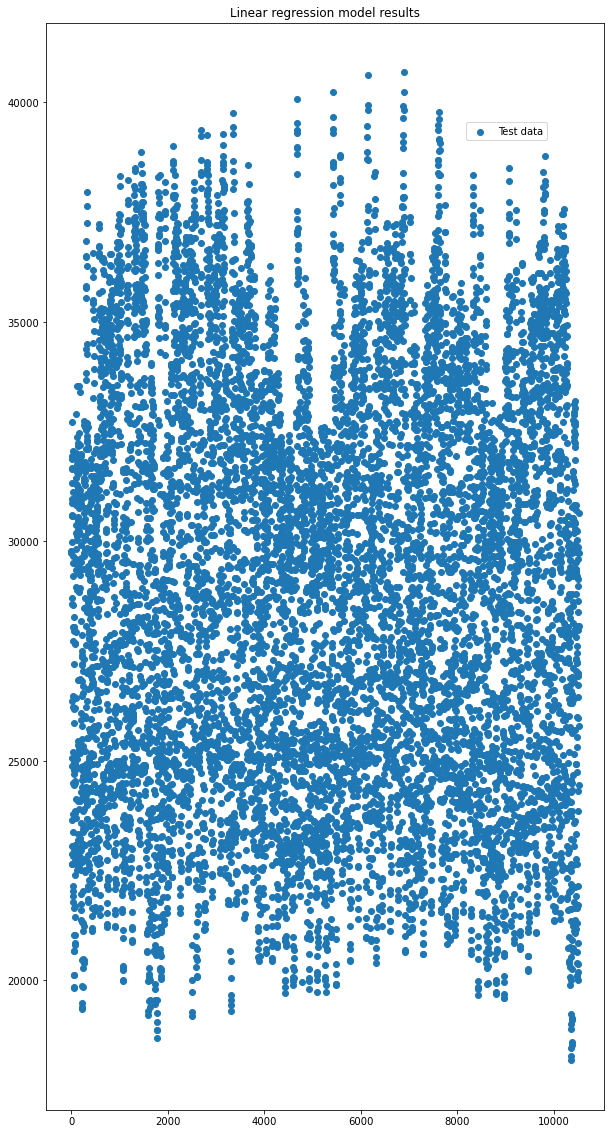

In [51]:
model = LinearRegression(normalize=True)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(f"Resulting mean absolute error is {mean_absolute_error(y_test, preds):.4f}, mean squared error is {mean_squared_error(y_test, preds):.4f}, determination coefficient is {r2_score(y_test, preds):.4f}")
x_domain = range(len(y_test))
plt.figure(figsize=(10,20))
plt.scatter(x_domain, y_test, label='Test data')
# plt.scatter(x_domain, preds, label='Predicted data')
plt.title('Linear regression model results')
plt.legend(loc="center right", borderaxespad=0.1, bbox_to_anchor=(0.9, 0.9))